In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Payne County, which has population 77350 and is centered at ( -96.97576957219881 , 36.077314347648766 )
Node 1 is Caddo County, which has population 29600 and is centered at ( -98.3751473673756 , 35.17437980539709 )
Node 2 is Delaware County, which has population 41487 and is centered at ( -94.80265082077914 , 36.40819871769282 )
Node 3 is Marshall County, which has population 15840 and is centered at ( -96.76913170667204 , 34.02448993509658 )
Node 4 is Greer County, which has population 6239 and is centered at ( -99.56080209644304 , 34.935704806492105 )
Node 5 is Coal County, which has population 5925 and is centered at ( -96.29785664485043 , 34.58819267124212 )
Node 6 is Seminole County, which has population 25482 and is centered at ( -96.61551788874691 , 35.167486064110506 )
Node 7 is Murray County, which has population 13488 and is centered at ( -97.06792003908163 , 34.48232870884322 )
Node 8 is Jefferson County, which has population 6472 and is centered at ( -97.83585114

In [4]:
# pip install geopy

In [5]:
# what is the "distance" between Payne County (node 0), Oklahoma County (node 15), and Tulsa County (node 23)?
from geopy.distance import geodesic

# Store centroid location as ( long, lat )
Payne = ( G.nodes[0]['C_Y'],  G.nodes[0]['C_X'] )
Oklahoma = ( G.nodes[15]['C_Y'], G.nodes[15]['C_X'] )
Tulsa = ( G.nodes[23]['C_Y'], G.nodes[23]['C_X'] )

# Print the distance in miles
print("Payne -> Oklahoma:",geodesic(Payne, Oklahoma).miles)
print("Oklahoma -> Tulsa:",geodesic(Oklahoma, Tulsa).miles)
print("Tulsa -> Payne:",geodesic(Tulsa, Payne).miles)

Payne -> Oklahoma: 43.60117970160248
Oklahoma -> Tulsa: 91.17444501284626
Tulsa -> Payne: 57.9517301598394


In [6]:
# create distance dictionary
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],  G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],  G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [7]:
# check the dictionary by printing the Payne County -> Oklahoma County distance
print("Payne -> Oklahoma:",dist[0,15])

Payne -> Oklahoma: 43.60117970160248


In [8]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 5          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 746519 and U = 754021 and k = 5


In [9]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY) 

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic


In [10]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*x[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [11]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [12]:
# Add contiguity constraints

import networkx as nx
DG = nx.DiGraph(G)

# Add variable f[j,u,v] which equals the amount of flow (originally from j) that is sent across arc (u,v)
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes()-1

# Add constraint saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes )

# Add constraints saying that node i can receive flow of type j only if i is assigned to j
m.addConstrs( gp.quicksum( f[j,u,i] for u in DG.neighbors(i)) <= M * x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

# If i is assigned to j, then i should consume one unit of j flow. 
#    Otherwise, i should consume no units of j flow.
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in DG.neighbors(i)) == x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()

In [13]:
# solve, making sure to set a 0.00% MIP gap tolerance(!)
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17942 rows, 35959 columns and 130582 nonzeros
Model fingerprint: 0x2d29c9df
Variable types: 30030 continuous, 5929 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+06, 8e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 824 rows and 1904 columns
Presolve time: 0.71s
Presolved: 17118 rows, 34055 columns, 124969 nonzeros
Variable types: 28244 continuous, 5811 integer (5811 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: object

In [14]:
print("The moment of inertia objective is",m.objval)

# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The moment of inertia objective is 8402531933.751296
District 0 has population 749255 and contains counties ['Caddo', 'Greer', 'Jefferson', 'Tillman', 'Harper', 'Grant', 'Dewey', 'Texas', 'Roger Mills', 'Kiowa', 'Beckham', 'Harmon', 'Major', 'Alfalfa', 'Beaver', 'Stephens', 'Jackson', 'Cimarron', 'Ellis', 'McClain', 'Grady', 'Blaine', 'Woodward', 'Kingfisher', 'Comanche', 'Cotton', 'Custer', 'Garfield', 'Washita', 'Logan', 'Canadian', 'Woods']
District 1 has population 752906 and contains counties ['Oklahoma', 'Lincoln']
District 2 has population 748413 and contains counties ['Tulsa', 'Kay', 'Washington', 'Osage']
District 3 has population 751778 and contains counties ['Delaware', 'McIntosh', 'Choctaw', 'Le Flore', 'Nowata', 'Atoka', 'Adair', 'Craig', 'Pushmataha', 'Mayes', 'Muskogee', 'Ottawa', 'Pittsburg', 'Latimer', 'Hughes', 'Sequoyah', 'Haskell', 'Cherokee', 'Wagoner', 'Okmulgee', 'Rogers', 'McCurtain']
District 4 has population 748999 and contains counties ['Payne', 'Marshall', '

In [15]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

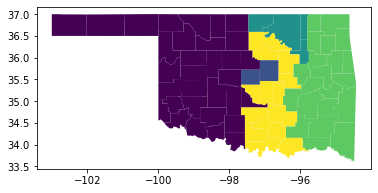

In [17]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()